# Laboratory 1: Examining New York City (NYC) Fire Incidents

### Team Members: Chase Henderson, Aditya Garapati, Carl Walenciak, Brian Waite


## Business Understanding

### Data General Description: 

The Fire Department of New York City (FDNY) collects data on all incidents handled by non-EMS units including fire, medical and non-fire emergencies. This data is more broadly collected in support of the New York Fire Incident Reporting System (NYFIRS) and the National Fire Incident Reporting System (NFIRS). According to the New York City Open Data platform (https://data.cityofnewyork.us) NFIRS data was originally intended to aid in understanding the nature and causes of fire, civilian fire casualties and firefighter injuries, but has since expanded to collect information on all incidents to which fire units respond. [1]

Although FDNY Incident data is available from 2013 through June, 2018, the total number of records for that period is approximately 2.5 Million and represented a challenge to computing resources available to the team. In order to limit the size of the data set, but still achieve the research objectives, the team downselected the data set to include only fire incident records from the six month period beginning 01-01-2018 at 12AM through 06-30-2018 at midnight. The resultant set contains 240,979 records with 25 original feature columns.

### Data Determined Out of Scope: 

As indicated above, the original FDNY Incident data set contains a variety of incident types including non-fire medical emergencies, gas leaks, support to police activity and wide variety of other events. In order to deliver meaningful analytic outcomes and focus on specific challenge problems, the selected data set includes only fire-related incidents (indicated within the data set as 100-series (1XX) incidents. 

### Supplemental Data: 

In order to enable the team to ask more robust questions of interest of the primary data, we sought additional associated or relevant data to supplement our analysis. This includes: 

* Firebox Location Data: Each incident within the primary data set is linked to a specific firebox. New York City's unique infrastructure includes a series of over 15,000 on-street fireboxes that allow easy access to emergency services. While many of these are in varying states of repair, the FDNY uses them as geographic reference points for the dispatch of units and the records kept in the primary dataset. The team sought and identified geo-reference data to improve the utility of the firebox field in the primary data set. This was obtained from reference [2]. Although this data is somewhat dated -- last updated in 2008 -- the age of the NYC Firebox system and the immobility of the devices makes us confident that the location information is unchanged. Data for 16,284 fireboxes is listed. 

* Firehouse Location Data: The team also sought and identified a complete listing of the name, type, and geo-reference data of all 213 firehouses in the boroughs of NYC. [3]

### Analytic Questions of Interest: 

Using this publicly available data set, the team has identified a number of potential analytic questions of interest that could potentially provide value to FDNY and NYC decision makers regarding the allocation of financial and personnel resources. Specific questions of interest could include: 

* Identification of regions of New York City where fire incidents are most likely to occur. 
* Prediction of the response time and/or total incident duration based on available features. 
* Identify trends within the data set that might indicate increased periods of risk. 

These insights could specifically be used to determine which fire stations should receive additional personnel or equipment resources or design staffing schedules to coincide with the most likely periods of fire related activity. 

Further, this analysis may help to aid in the identification of problem neighborhoods where increased inspection activity or public education campaigns could help to contribute to additional fire prevention measures being deployed in a proactive fashion by city decision makers. 

### Measuring Outcomes from the Data: 

The team believes that this data set can support a variety of analytic methodologies and provide interesting answers to the question of interest above. Techniques available will include both classification and regression based models. In order to ensure validity of results, all evaluations of data will be on a 70/30 train/test split of the data with test data being withheld for final testing and not made available for model improvement at any stage of the analysis. 

Below we describe our evaluative criteria for each type of model anticipated: 

In all cases, our models will be evaluated on whether the findings are logical and representative of reasonable outcomes given the data provided and are consistent with the exploratory data analysis. 

*Linear Regression:* 

Feature selection for inclusion in the model will likely make use of feature down-selection techniques including forward, backward, LASSO or ELASTIC-NET selection techniques with Bayesian Information Criteria, Adjusted R-Squared, and Residual Sum of Squares acting as the primary selection criteria. These criteria will also be used to evaluate the model fit in comparison to the test data set. 

*Classification:*

Evaluation of classification models will be through the use of confusion matrix based statistics including accuracy, sensitivity and specificity. In addition, the Area Under the Curve (AUC) assessments using Receiver Operating Characteristic (ROC) curve analysis will be used to compare model performance and to evaluate the performance of any final selected model. 

In [1]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy
# pip install geopy
# pip install numpy
# pip install seaborn
# pip install matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#You might need to 'pip install geopy' and it doesn't seem to work on Python 3.7
import geopy.distance
from sodapy import Socrata
from mpl_toolkits.basemap import Basemap


# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tm6d-hbzd", limit = 250000)#limit=300000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

#Get the firehouse location information
firehouse_info = client.get("hc8x-tcnd", limit=10000)

firehouse_df = pd.DataFrame.from_records(firehouse_info)
firehouse_df = firehouse_df.dropna()

#Get the firebox location information
firebox_locs = pd.read_csv("Fire Data\\Fire Boxes.csv", names=['LONG','LAT','fire_box','nearest_intersection'])

In [2]:
results_df.head()

,im_incident_key,fire_box,incident_type_desc,incident_date_time,arrival_date_time,units_onscene,last_unit_cleared_date_time,highest_level_desc,total_incident_duration,action_taken1_desc,...,zip_code,borough_desc,floor,co_detector_present_desc,story_fire_origin_count,fire_spread_desc,detector_presence_desc,aes_presence_desc,standpipe_sys_present_flag,fire_origin_below_grade_flag
0,63476768,2928,"746 - Carbon monoxide detector activation, no CO",2018-06-30T23:55:29.000,2018-07-01T00:00:32.000,2,2018-07-01T00:22:57.000,11 - First Alarm,1648,"42 - HazMat detection, monitoring, sampling, &...",...,10453,2 - Bronx,1,Yes,NaN,NaN,NaN,NaN,NaN,NaN
1,63476763,1021,"300 - Rescue, EMS incident, other",2018-06-30T23:54:44.000,2018-06-30T23:58:59.000,1,2018-07-01T00:09:29.000,11 - First Alarm,885,"00 - Action taken, other",...,11203,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63476761,2745,"651 - Smoke scare, odor of smoke",2018-06-30T23:54:13.000,2018-06-30T23:58:29.000,3,2018-07-01T00:07:50.000,11 - First Alarm,817,"00 - Action taken, other",...,10456,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63476762,2135,"117 - Commercial Compactor fire, confined to r...",2018-06-30T23:54:08.000,2018-06-30T23:58:53.000,5,2018-07-01T00:19:16.000,11 - First Alarm,1508,11 - Extinguishment by fire service personnel,...,10454,2 - Bronx,basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63476759,1877,"710 - Malicious, mischievous false call, other",2018-06-30T23:53:33.000,2018-06-30T23:56:50.000,1,2018-06-30T23:57:11.000,11 - First Alarm,218,"00 - Action taken, other",...,11208,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#convert dates to date time objects
results_df['arrival_date_time']=pd.to_datetime(results_df['arrival_date_time'])
results_df['incident_date_time']=pd.to_datetime(results_df['incident_date_time'])
results_df['last_unit_cleared_date_time']=pd.to_datetime(results_df['last_unit_cleared_date_time'])

In [4]:
#Limit results to 2018
results_df = results_df[results_df['incident_date_time'] > pd.to_datetime('2018-01-01 00:00:00')]

In [5]:
#Convert the columns to appropriate types. Probably more to do here. 
results_df['response_time'] = (results_df['arrival_date_time'] - results_df['incident_date_time'])
results_df['response_time'] = pd.to_numeric(results_df['response_time'])
results_df['units_onscene'] = pd.to_numeric(results_df['units_onscene'])
results_df['total_incident_duration'] = pd.to_numeric(results_df['total_incident_duration'])
results_df['story_fire_origin_count'] = pd.to_numeric(results_df['story_fire_origin_count'])
results_df['response_time'] = results_df['response_time']/ 60000000000

results_df['fire_box'] = results_df['fire_box'].astype('str')

#Convert firehouse values
firehouse_df['latitude'] = pd.to_numeric(firehouse_df['latitude'])
firehouse_df['longitude'] = pd.to_numeric(firehouse_df['longitude'])

In [6]:
#Just to show you how we are converting the firebox to match the fire_box dataframe for merging
results_df.borough_desc.unique()

array(['2 - Bronx', '4 - Brooklyn', '1 - Manhattan', '5 - Queens',
       '3 - Staten Island'], dtype=object)

In [7]:
#Add the borough code to the firebox column
results_df.loc[results_df['borough_desc'].str.match('1 - Manhattan'), 'fire_box'] = 'M' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('2 - Bronx'), 'fire_box'] = 'X' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('3 - Staten Island'), 'fire_box'] = 'R' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('4 - Brooklyn'), 'fire_box'] = 'B' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('5 - Queens'), 'fire_box'] = 'Q' + results_df.fire_box

In [8]:
from geopy import distance
def findNearestFirestation (Lat, Long):
    minDistance = 1000
    for fireLat, fireLong in zip(firehouse_df.latitude, firehouse_df.longitude):
        distanceFire = distance.distance((Lat, Long), (fireLat,fireLong)).miles
        if distanceFire < minDistance: 
            minDistance = distanceFire
    return minDistance

In [9]:
#Merge the fire_box dataframe with the overall dataframe
final_df = pd.merge(results_df, firebox_locs, on = 'fire_box')
final_df['LAT'] = pd.to_numeric(final_df['LAT'])
final_df['LONG'] = pd.to_numeric(final_df['LONG'])

In [10]:
#Get the nearest fire station
#This code takes a long time to run because it needs to calculate the distance for each firebox to all fire stations and then select the minimum.
#final_df['Distance_To_Nearest_Station'] = 0
#i = 0
#for lat, long in zip (final_df.LAT, final_df.LONG): 
#     dist = findNearestFirestation(lat,long)
#     final_df['Distance_To_Nearest_Station'].iloc[i] = dist
#     i = i + 1


Display the final dataframe. 

In [11]:
final_df.tail(100)

,im_incident_key,fire_box,incident_type_desc,incident_date_time,arrival_date_time,units_onscene,last_unit_cleared_date_time,highest_level_desc,total_incident_duration,action_taken1_desc,...,story_fire_origin_count,fire_spread_desc,detector_presence_desc,aes_presence_desc,standpipe_sys_present_flag,fire_origin_below_grade_flag,response_time,LONG,LAT,nearest_intersection
169364,62635272,B2389,522 - Water or steam leak,2018-01-08 23:06:53,2018-01-08 23:09:21,6.0,2018-01-08 23:21:58,11 - First Alarm,905.0,64 - Shut down system,...,NaN,NaN,NaN,NaN,NaN,NaN,2.466667,-73.90891,40.63002,Paerdegat Avenue N & Paerdegat 6th St
169365,62633023,Q4639,"651 - Smoke scare, odor of smoke",2018-01-08 18:17:11,2018-01-08 18:32:38,1.0,2018-01-08 18:34:04,11 - First Alarm,1013.0,"00 - Action taken, other",...,NaN,NaN,NaN,NaN,NaN,NaN,15.450000,-73.80333,40.79435,Powells Cove Blvd && 158th St
169366,62632603,R1274,522 - Water or steam leak,2018-01-08 17:37:11,2018-01-08 17:45:32,1.0,2018-01-08 17:46:12,11 - First Alarm,541.0,64 - Shut down system,...,NaN,NaN,NaN,NaN,NaN,NaN,8.350000,-74.07710,40.59980,Steuben St & Radcliff Rd
169367,62631948,Q9307,522 - Water or steam leak,2018-01-08 16:30:19,2018-01-08 16:52:03,1.0,2018-01-08 17:12:55,11 - First Alarm,2556.0,64 - Shut down system,...,NaN,NaN,NaN,NaN,NaN,NaN,21.733333,-73.84578,40.76053,Northern Blvd && 126th St
169368,62630152,Q9307,522 - Water or steam leak,2018-01-08 13:19:51,2018-01-08 13:28:28,1.0,2018-01-08 14:10:19,11 - First Alarm,3028.0,64 - Shut down system,...,NaN,NaN,NaN,NaN,NaN,NaN,8.616667,-73.84578,40.76053,Northern Blvd && 126th St
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169459,62581297,X4349,"300 - Rescue, EMS incident, other",2018-01-01 09:28:37,2018-01-01 10:00:58,1.0,2018-01-01 10:38:36,"1 - More than initial alarm, less than Signal 7-5",4199.0,"00 - Action taken, other",...,NaN,NaN,NaN,NaN,NaN,NaN,32.350000,-73.83629,40.86070,Waring Ave & Gunther Ave
169460,62581241,Q6320,"300 - Rescue, EMS incident, other",2018-01-01 09:18:00,2018-01-01 09:24:18,1.0,2018-01-01 09:29:24,"1 - More than initial alarm, less than Signal 7-5",684.0,"00 - Action taken, other",...,NaN,NaN,NaN,NaN,NaN,NaN,6.300000,-73.79196,40.75696,189th St && 43 Rd
169461,62581161,Q9711,522 - Water or steam leak,2018-01-01 09:03:51,2018-01-01 09:09:05,1.0,2018-01-01 09:22:17,"1 - More than initial alarm, less than Signal 7-5",1106.0,64 - Shut down system,...,NaN,NaN,NaN,NaN,NaN,NaN,5.233333,-73.78770,40.72983,75th Ave && 182nd St
169462,62580911,Q6539,"300 - Rescue, EMS incident, other",2018-01-01 07:32:35,2018-01-01 07:37:35,1.0,2018-01-01 08:38:36,"1 - More than initial alarm, less than Signal 7-5",3961.0,"00 - Action taken, other",...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,-73.79976,40.72155,81st Ave && 168th St


**AS we can see below , StatenIsland  has  very  less incidents compared to other buroughs, this makes sense as Staten Island is the Least populated Buroughs out of all the Burougs** 

In [12]:
def groupByBurough (df):
    grouped = df.groupby('borough_desc')
    for name,group in df.groupby('borough_desc'):
        print('Incidents in Burough' + name , group.shape[0])
    
    return grouped.borough_desc.count()
    

In [13]:
groupByBurough(final_df)

Incidents in Burough1 - Manhattan 26836
Incidents in Burough2 - Bronx 45462
Incidents in Burough3 - Staten Island 5269
Incidents in Burough4 - Brooklyn 45959
Incidents in Burough5 - Queens 45938


borough_desc
1 - Manhattan        26836
2 - Bronx            45462
3 - Staten Island     5269
4 - Brooklyn         45959
5 - Queens           45938
Name: borough_desc, dtype: int64

## References: 

[1] @ELECTRONIC{firedata,
  author = {Fire Department of New York City (FDNY)},
  year = {2019},
  title = {Incidents Responded to by Fire Companies},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd},
  owner = {NYC Open Data},
  timestamp = {2019.03.21}
}

[2] @ELECTRONIC{fireboxdata,
  author = {www.poi-factory.com)},
  year = {2008},
  title = {FDNY Firebox Locator Data},
  language = {English},
  howpublished = {\url=http://www.poi-factory.com/node/11074},
  owner = {POI Factory},
  timestamp = {2008.02.26}
}

[3] @ELECTRONIC{firehousedata,
  author = {Fire Department of New York City (FDNY))},
  year = {2018},
  title = {FDNY Firehouse Listing},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/FDNY-Firehouse-Listing/hc8x-tcnd},
  owner = {NYC Open Data},
  timestamp = {2018.09.10}
}

In [14]:
results_df.shape

(240979, 25)

In [15]:
results_df.incident_date_time.max()

Timestamp('2018-06-30 23:55:29')

In [16]:
firehouse_df.shape

(213, 12)

In [17]:
firebox_locs.shape

(16284, 4)

In [18]:
#Uncomment to save the fire data when you are creating from scratch
#final_df.to_pickle('Fire Data/fireData.pkl')

In [19]:
final_df = pd.read_pickle('Fire Data/fireData.pkl')

## Map Experiment

In [47]:
import os
import shapefile
shpfile = os.path.expanduser('Fire Data/Maps/nyc2')
sf = shapefile.Reader(shpfile)

In [52]:
final_df.LONG.max()

-73.32655

In [53]:
final_df.LONG.min()

-74.2542

C:\Users\Brian\Anaconda3\envs\Python3_6\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Brian\Anaconda3\envs\Python3_6\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


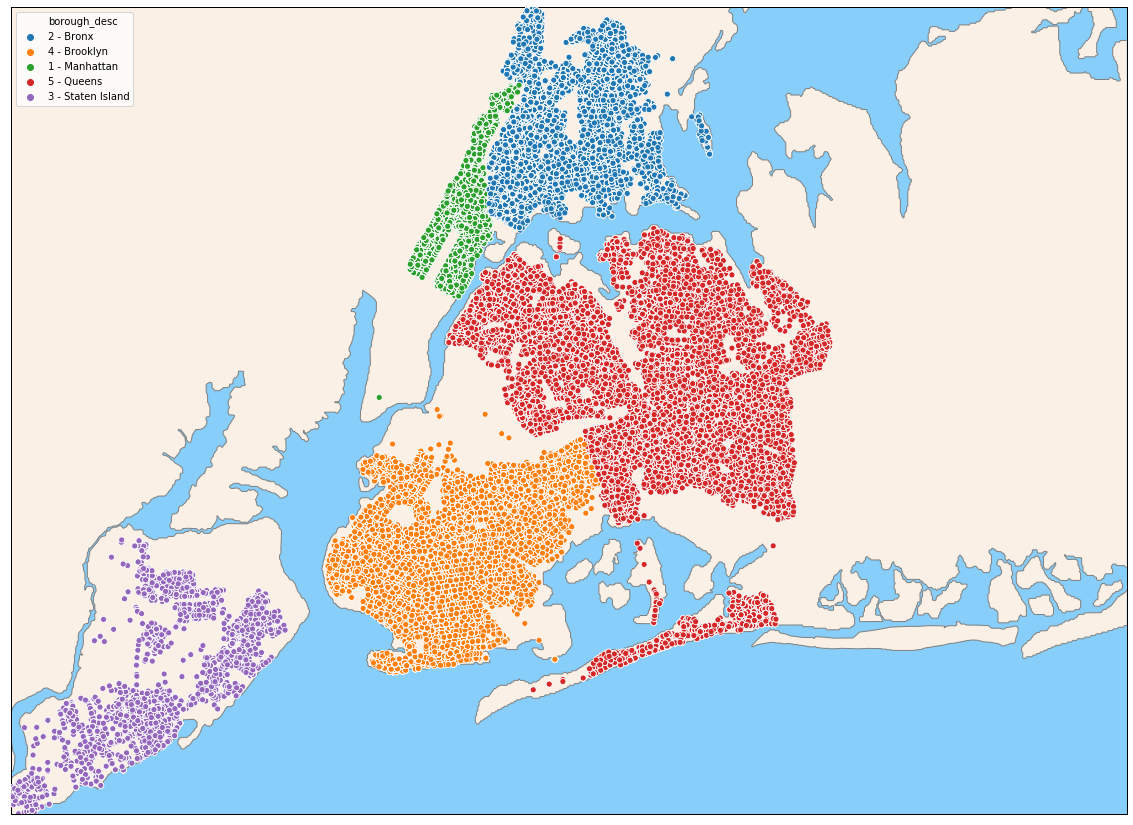

In [88]:
#Commenting out because you won't meet the dependencies if you pull this. 


# fig = plt.figure(figsize=(20, 20))
# m = Basemap(projection='tmerc', resolution='f', llcrnrlon = final_df.LONG.min(), llcrnrlat = final_df.LAT.min(),
# urcrnrlon = -73.5, urcrnrlat = final_df.LAT.max(), lat_0 = final_df.LAT.mean(), lon_0 = final_df.LONG.mean())
# m.drawmapboundary(fill_color='lightskyblue')
# m.fillcontinents(color='linen',lake_color='lightskyblue')
# m.drawcoastlines(color='gray')
# m.drawrivers(color='lightskyblue')
# #Fill the globe with a blue color 

# #Fill the continents with the land color

# #Include this for the building footprint map
# #m.readshapefile(shpfile, 'metro', linewidth=.15)
# x, y = m(final_df.LONG.tolist(), final_df.LAT.tolist())
# sns.scatterplot(x,y, hue = final_df.borough_desc, zorder = 15)

# plt.show()



Interesting that we are missing some areas and have some outliers. Far to the east there is a single point. Missing parts of Staten Island, Brooklyn and Southern Manhattan seem to indicate missing data. This most closely aligns with community districts as indicated here: http://gis.nyc.gov/doitt/nycitymap/ and the EMS response districts here: https://ibo.nyc.ny.us/images/map1.jpg. Shape files are not available for these regions, but they seem roughly to align and would indicate non-reporting regions. 

## This is Aditya's Code

In [ ]:
##Begin Aditya's Code

def groupByBurough_dwelling (df):
   grouped = df.groupby('borough_desc')
   for name,group in df.groupby('borough_desc'):
               plt.figure(name)
               sns.countplot(y="property_use_desc",data=group,order=group.property_use_desc.value_counts().iloc[:5].index).set_title(name)
   return

from datetime import datetime

def groupByBurough_callTime (df):
   for name,group in df.groupby('borough_desc'):
       print(name)
       df2=group.set_index('arrival_date_time')
       ts_df=df2.loc[df2.index.notnull()]
       ts_df.index = pd.to_datetime(ts_df.index)
       ts_df['hour_of_call'] = ts_df.index.hour
       plt.figure(name)
       sns.countplot(x="hour_of_call",data=ts_df).set_title(name)
   return

In [ ]:
## Call Aditya's functions
groupByBurough_dwelling(final_df)


In [ ]:
groupByBurough_callTime(final_df)

## Carl's Imputation code: 

In [92]:
# Create On Scene Cross Reference
df2 = pd.DataFrame(results_df[results_df['units_onscene'].isnull()== False][['action_taken1_desc', 'units_onscene']])
df2 = df2.rename(columns = {"units_onscene":"onscene_mean"})
df2 = df2.groupby('action_taken1_desc').mean()
# Merge Data with Mean XRef
df = df.merge(df2, how = 'left', on = 'action_taken1_desc', indicator = True)
# Set On Scene where Null
df.loc[df['units_onscene'].isnull(), 'units_onscene'] = df[df['units_onscene'].isnull()]['onscene_mean']
msno.matrix(df)


ValueError: Cannot use name of an existing column for indicator column